### Initial setup

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

#tuning
from sklearn.model_selection import RandomizedSearchCV

import lightgbm as lgb
import xgboost as xgb

# import warnings
# warnings.filterwarnings("ignore")

# from matplotlib import pyplot as plt

/opt/homebrew/Caskroom/miniforge/base/envs/python38/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


#### Read, clean & add features

In [62]:
df = pd.read_excel("expenses-monthly.xlsx",sheet_name='Sheet 1')
df['Date'] = pd.to_datetime(df['Month of Date'], format="%m/%d/%Y")
df.drop(['INDEX()','Month of Date'],axis=1,inplace=True)

#date part features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Quarter'] = df['Date'].dt.quarter

df['Expense Amount'] = np.log(df['Expense Amount'])
df['Number of Employees'] = np.log(df['Number of Employees'])

#Hot Encoding
df = pd.get_dummies(df, columns=['Department','Expense Type'])

df

,Expense Amount,Number of Employees,Date,Year,Month,Quarter,Department_Accounting,Department_C-level,Department_Engineering,Department_Human Resources,Department_Sales,Department_Support,Expense Type_Meals,Expense Type_Miscellaneous,Expense Type_Operations,Expense Type_Travel
0,6.413983,0.693147,2019-01-01,2019,1,1,1,0,0,0,0,0,1,0,0,0
1,6.553933,0.000000,2019-01-01,2019,1,1,1,0,0,0,0,0,0,1,0,0
2,6.726293,1.098612,2019-01-01,2019,1,1,1,0,0,0,0,0,0,0,1,0
3,6.350152,1.098612,2019-01-01,2019,1,1,1,0,0,0,0,0,0,0,0,1
4,6.647649,0.000000,2019-01-01,2019,1,1,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,11.097021,3.688879,2020-12-01,2020,12,4,0,0,0,0,1,0,0,0,0,1
480,8.672608,3.433987,2020-12-01,2020,12,4,0,0,0,0,0,1,1,0,0,0
481,6.919249,2.397895,2020-12-01,2020,12,4,0,0,0,0,0,1,0,1,0,0
482,9.362606,3.496508,2020-12-01,2020,12,4,0,0,0,0,0,1,0,0,1,0


array([[<AxesSubplot:title={'center':'Expense Amount'}>,
        <AxesSubplot:title={'center':'Number of Employees'}>]],
      dtype=object)

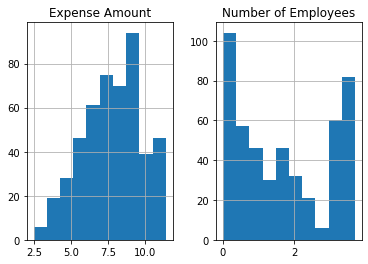

In [63]:
df.dtypes
df[['Expense Amount','Number of Employees']].hist()

#df[['Expense Amount','Number of Employees']].corr()

#### Train, test values

In [64]:
#Breaking the data and selecting features , predictors
predictors=df.drop(['Expense Amount','Date'],axis=1)
target=df['Expense Amount']
x_train,x_cv,y_train,y_cv=train_test_split(predictors,target,test_size=0.2,random_state=42)

### Modelling

In [65]:
#Comparing Algorithms
def scores(i):
    lin = i()
    lin.fit(x_train, y_train)
    y_pred=lin.predict(x_cv)
    lin_r= r2_score(y_cv, y_pred)
    s.append(lin_r)
#Checking the scores by using our function
algos=[LinearRegression,KNeighborsRegressor,
       RandomForestRegressor,Lasso,ElasticNet,DecisionTreeRegressor]
s=[]
for i in algos:
    scores(i)

models = pd.DataFrame({
    'Method': ['LinearRegression', 'KNeighborsRegressor',
               'RandomForestRegressor', 'Lasso','DecisionTreeRegressor'],
    'Score': [s[0],s[1],s[2],s[3],s[4]]})
models.sort_values(by='Score', ascending=False)

,Method,Score
2,RandomForestRegressor,0.878946
1,KNeighborsRegressor,0.722899
0,LinearRegression,0.637186
4,DecisionTreeRegressor,0.443256
3,Lasso,0.414516


#### Random Forest

In [66]:
predictionsDict = {}

model = RandomForestRegressor()
model.fit(x_train,y_train)
y_pred = model.predict(x_cv)
predictionsDict['RandomForest'] = y_pred
r2_score(y_cv,y_pred)

0.8818447308329792

#### XGBoost

In [67]:
#reg = xgb.XGBRegressor(subsample = 0.9, n_estimators = 1000, max_depth = 20, learning_rate = 0.1, colsample_bytree = 0.9, colsample_bylevel = 0.9)
reg = xgb.XGBRegressor()

reg.fit(x_train, y_train,
        verbose=False, early_stopping_rounds=15,eval_set=[(x_cv,y_cv)])  # Change verbose to True if you want to see it train
y_pred = reg.predict(x_cv)
predictionsDict['XGBoost'] = y_pred
r2_score(y_cv,y_pred)

/opt/homebrew/Caskroom/miniforge/base/envs/python38/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


0.9325250127930836

##### XGBoost Tuner

In [ ]:
params = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100, 500, 1000]}
xgbr = xgb.XGBRegressor(seed = 20)
clf = RandomizedSearchCV(estimator=xgbr,
                         param_distributions=params,
                         scoring='neg_mean_squared_error',
                         n_iter=25,
                         verbose=1)
clf.fit(x_train, y_train)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

#### LightGBM

In [68]:
lightGBM = lgb.LGBMRegressor()
lightGBM.fit(x_train, y_train)
y_pred = lightGBM.predict(x_cv)
predictionsDict['Lightgbm'] = y_pred
r2_score(y_cv, y_pred)

0.7974566582310981

#### Compare model residuals

In [40]:
#compare models
models = ['RandomForest',
          'Lightgbm',
          'XGBoost']
resis = pd.DataFrame(data={k: y_cv -
                              v for k, v in predictionsDict.items()})[models]
corr = resis.corr()
print("Residuals correlation")
corr.style.background_gradient(cmap='coolwarm')

Residuals correlation


,RandomForest,Lightgbm,XGBoost
RandomForest,1.000000,0.869390,0.800197
Lightgbm,0.869390,1.000000,0.702872
XGBoost,0.800197,0.702872,1.000000


### Predict with Random Forest

In [69]:
split_date = pd.datetime(2020,12,1)

raw = pd.read_excel("expenses-monthly.xlsx",sheet_name='Sheet 1')
raw['Date'] = pd.to_datetime(raw['Month of Date'], format="%m/%d/%Y")
raw.drop(['INDEX()','Month of Date'],axis=1,inplace=True)

raw = raw.loc[raw['Date'] >= split_date]

df_training = df.loc[df['Date'] < split_date]
df_future = df.loc[df['Date'] >= split_date]

predictors = df_training.drop(['Expense Amount','Date'],axis=1)
target = df_training['Expense Amount']
future = df_future.drop(['Expense Amount','Date'],axis=1)

model.fit(predictors, target)
raw['rf'] = np.exp(model.predict(future))

reg.fit(predictors, target)
raw['xgb'] = np.exp(reg.predict(future))

lightGBM.fit(predictors, target)
raw['lgbm'] = np.exp(lightGBM.predict(future))

#raw.drop('Expense Amount',axis=1,inplace=True)
raw.to_csv('future-expenses.csv',index=False)
raw

# export = pd.concat([df, future])
# with pd.ExcelWriter("~/Downloads/calls.xlsx", engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
#     export.to_excel(writer, 'Future', index=False)

/var/folders/4z/q2mxf7h14d7d2xg4_lsrtjcc0000gn/T/ipykernel_1649/587532147.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  split_date = pd.datetime(2020,12,1)
/opt/homebrew/Caskroom/miniforge/base/envs/python38/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


,Department,Expense Type,Expense Amount,Number of Employees,Date,rf,xgb,lgbm
464,Accounting,Operations,35.31,1,2020-12-01,60.905080,34.903629,75.095700
465,C-level,Meals,3844.51,2,2020-12-01,1101.021501,1918.670288,845.918164
466,C-level,Operations,831.67,2,2020-12-01,513.523212,1344.370239,667.603523
467,C-level,Travel,3830.45,2,2020-12-01,3175.615227,2347.558838,2984.501307
468,Engineering,Meals,783.57,5,2020-12-01,1001.538638,815.459351,1292.345516
469,Engineering,Miscellaneous,635.17,4,2020-12-01,997.367449,631.616699,2060.377562
470,Engineering,Operations,30288.20,4,2020-12-01,26458.543521,29309.792969,13058.258096
471,Engineering,Travel,1716.32,5,2020-12-01,2868.863552,1959.491089,5564.907994
472,Human Resources,Meals,105.57,1,2020-12-01,125.061422,102.985062,121.067909
473,Human Resources,Miscellaneous,284.83,3,2020-12-01,434.142125,290.871368,554.225570
